<a href="https://colab.research.google.com/github/bhattacharjee/msc-ai-project/blob/main/iteration_2.1/COLABTEST_iteration_2_1_LR_compare_base32_logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Few key observations
- If both and non-encrypted files are base-32 encoded, accuracy drops really low.
   * Even in this case, fourier analysis (specifically autocorrelation and mean) provide good discrminators
   * Renyi's entropy at alpha=infinity gives good discrimination
   * Overall we see around 13% improvement in F1-score
- Specifically for webpfiles
   * We see that higher moments of around 14 gives a good discrimination
   * Fourier analysis still gives benefits here
- For webpfiles where both unencrypted and encrypted content are base32 encrypted
   * Fourier analysis is still beneficial
- For Non-webp files where plaintext is not base-32 encrypted
   * Accuracy is decent with just the base parameters, but with fourier analysis, we can close to perfect detection


# Contents
- ## [Implementation](#mplementation)
 - ### [List of Files](#list-of-files)
 - ### [Utility to call gc](#gc)
 - ### [Selection of Columns](#select-columns)
 - ### [Function to compare the three selections of columns for a given dataset](#compare-fn)
 - ### [Load the datasets](#load-dataset)
 - ### [Select the datasets](#dataset-selection)
 - ### [Run all combinations of data](#dataset-selection)
- ## [Results](#results)
 - ### [Print the raw results](#raw-results)
 - ### [Sort by the improvement when using Fourier transforms over baseline](#sorted-fourier)
 - ### [Measure improvement when only webp files are used](#webp-only)
 - ### [Measure improvement when webp files are not present](#no-webp)
 - ### [Measure improvement for balanced datasets](#balanced-dataset)
 - ### [Measure the improvement when all files are used](#full-dataset)
 - ### [Focus on items where the base metrics performed well](#focus-greater-90)
 - ### [Correlation of data set and performance]("corr-heatmap")
 - ### [Average out all the metrics](#mean-fscores)
 


## Implementation <a class="anchor" id="implementation">
    
[top](#Contents)

In [1]:
!pip install -q "tqdm>=4.36.1"

import pandas as pd
import numpy as np
import scipy
from scipy import stats
import os

from functools import lru_cache

import gc

import sklearn
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score, accuracy_score

import matplotlib.pyplot as plt
import glob

import tqdm

from google.colab import drive

from google.colab import drive
drive.mount('/content/gdrive')

!mkdir /root/workdir
!cp /content/gdrive/MyDrive/MSCPROJDATA/*.gz /root/workdir
plt.rcParams["figure.figsize"] = (20,20)
os.chdir("/root/workdir")
print(os.getcwd())

Mounted at /content/gdrive
/root/workdir


In [2]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              4
On-line CPU(s) list: 0-3
Thread(s) per core:  2
Core(s) per socket:  2
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               79
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
Stepping:            0
CPU MHz:             2199.998
BogoMIPS:            4399.99
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            56320K
NUMA node0 CPU(s):   0-3
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_sin

### List of files <a class="anchor" id="list-of-files">

[top](#Contents)

In [3]:
!ls

expanded.plaintext.base32.parquet.gz	   expanded.pyencrypted_v2.parquet.gz
expanded.pyencrypted_v1.b32.parquet.gz	   plaintext.base32.combined.parquet.gz
expanded.pyencrypted_v1.parquet.gz	   plaintext.combined.parquet.gz
expanded.pyencrypted_v2.base32.parquet.gz  plaintext.expanded.parquet.gz


### Utility to call GC <a class="anchor" id="gc">
    
[top](#Contents)

In [ ]:
def call_gc():
    for i in range(3):
        for j in range(3):
            gc.collect(j)

### Selection of columns <a class="anchor" id="select-columns">
    
This function is used to select the columns.
There are three different configurations:
    
    1. Baseline - statistics like autocorrelation, shannon entropy, chi-square etc. are used
    
    2. Advanced - More statistics like moments, Tsallis and Renyi entropy, higher moments etc.
    
    3. Fourier - Some statistics of the Fourier Power Spectrum distribution
    
[top](#Contents)

In [ ]:
def get_columns(thisdf):
    baseline_columns = [c for c in thisdf.columns if c.startswith('baseline') and "head" not in c and "tail" not in c]
    baseline_columns = [c for c in baseline_columns if "filesize" not in c]
    baseline_columns = [c for c in baseline_columns if "begin" not in c and "end" not in c]

    advanced_columns = [c for c in thisdf.columns if "advanced" in c]
    advanced_columns = [c for c in advanced_columns if "begin" not in c and "end" not in c]
    advanced_columns = [c for c in advanced_columns if "head" not in c and "tail" not in c]
    advanced_columns = [c for c in advanced_columns if "start" not in c]
    advanced_columns_only = list(set(advanced_columns))
    advanced_columns = list(set(advanced_columns + baseline_columns))

    fourier_columns = [c for c in thisdf.columns if "fourier" in c and "value" not in c]
    fourier_columns = [c for c in fourier_columns if "1byte" in c]
    fourier_columns = [c for c in fourier_columns if "begin" not in c and "end" not in c]
    fourier_columns = [c for c in fourier_columns if "head" not in c and "tail" not in c]
    fourier_columns = [c for c in fourier_columns if "start" not in c]
    fourier_columns_only = list(set(fourier_columns))
    fourier_columns = list(set(advanced_columns + fourier_columns))
    
    return {\
        "baseline": baseline_columns,\
        "advanced": advanced_columns,\
        "advanced-only": advanced_columns_only,\
        "fourier": fourier_columns,\
        "fourier-only": fourier_columns_only,\
    }


### Function to compare the three selections of columns for a given dataset <a class="anchor" id="compare-fn">
    
For the three different sets of measurements described above, compare all the three sets for their f1 score
    
[top](#Contents)

In [ ]:
def compare_feature_selections(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    columns_dict = get_columns(X)
    ret = dict()
    for name, collist in columns_dict.items():
        XX_train, XX_test = X_train[collist], X_test[collist]
        #rfc = RandomForestClassifier(n_jobs=10, random_state=42)
        lr = LogisticRegression(n_jobs=10, random_state=42, max_iter=300)
        estimators = [('std,', MinMaxScaler()), ('LogisticRegression', lr)]
        pipeline = Pipeline(estimators)
        pipeline.fit(XX_train, y_train)
        y_pred = pipeline.predict(XX_test)
        f1 = f1_score(y_test, y_pred)
        ret[f"{name}-f1_score"] = f1
    return ret

def compare_feature_selections_wrapper(data):
    X = data[[c for c in data.columns if "is_encrypted" != c]]
    y = data["is_encrypted"]
    return compare_feature_selections(X, y)

### Load the datasets <a class="anchor" id="load-dataset">

We don't want to load the datasets again and again, so we load them once.
The LRU cache ensures that the next time this is called, we don't load the datasets again.
    
[top](#Contents)

In [ ]:
@lru_cache
def load_datasets_once():
    """Load all datasets only once
    
    We want to load the datasets only once. Once loaded
    serve from cache
    """
    datasets = dict()
    for file in glob.glob("*.parquet.gz"):
        df = pd.read_parquet(file)
        df = df.sample(frac=1).reset_index(drop=True)
        df["is_encrypted"] = 1 if "encr" in file.lower() else 0
        datasets[file] = df
    return datasets

### Select the datasets <a class="anchor" id="dataset-selection">

Select the dataset, combine it, shuffle it and return
    
We used several schemes:
* Plaintext
  - The base plaintext dataset of around 50k files
  - Expanded dataset, where all files that were less than 1500 bytes were expanded by repeating the file
  - Base32 encoding of
   - original plaintext
   - expanded plaintext
* Encryption : We used two schemes for encruption
  - v1 : AES 256 encryption of the full file, again two varieties were used
    - Plain encryption
    - Encryption followed by base32 encoding
  - v2 : AES encryption of the file, the first and the last 128 bytes are not encrypted. Of the remaining file, every alternate 16 bytes are encrypted.
    - Plain encryption
    - encryption followed by base32 encoding
    
We select combinations of the above datasets
    
Furthermore, we add further combinations by including and excluding webp files, and including and excluding non-webp files.
    
[top](#Contents)

In [ ]:
def get_dataset(\
               exclude_plaintext_nonbase32=False,
               exclude_plaintext_base32=False,
               exclude_encrypted_v1=False,
               exclude_encrypted_v2=False,
               exclude_encrypted_base32=False,
               exclude_encrypted_nonbase32=False,
               exclude_webp=False,
               exclude_nonwebp=False):
    description = {k:v for k,v in locals().items() if "exclude" in k}
    files = glob.glob("*.parquet.gz")
    
    
    if exclude_plaintext_nonbase32:
        files = [f for f in files if \
                     "plaintext" not in f \
                     or "_base32" in f \
                     or "_b32" in f]
    if exclude_plaintext_base32:
        files = [f for f in files if\
                    "plaintext" not in f or \
                    ("base32" not in f and "b32" not in f)]
    if exclude_encrypted_v1:
        files = [f for f in files if\
                    "_v1" not in f or "encr" not in f]
    if exclude_encrypted_v2:
        files = [f for f in files if \
                    "_v2" not in f or "encr" not in f]
    if exclude_encrypted_base32:
        files = [ f for f in files if\
                    "encr" not in f or\
                    ("base32" not in f and "b32" not in f)]
    if exclude_encrypted_nonbase32:
        files = [f for f in files if \
                    "encr" not in f or \
                    "base32" in f or "b32" in f]
        
        
    encrypted_count = len([f for f in files if "encr" in f])
    non_encrypted_count = len([f for f in files if "encr" not in f])
    
    if 0 == encrypted_count or 0 == non_encrypted_count or 0 == len(files):
        return description, None, -1, -1
    
    all_dfs = list()
    all_loaded_datasets = load_datasets_once()
    for filename in files:
        all_dfs.append(all_loaded_datasets[filename])
    
    combined_df = pd.concat(all_dfs)
    
    if exclude_webp:
        combined_df = combined_df[combined_df["extended.extension"] != ".webp"]
    if exclude_nonwebp:
        combined_df = combined_df[combined_df["extended.extension"] == ".webp"]
        
    if len(combined_df) == 0:
        return description, None, -1, -1
    
        
    encrypt_count = len(combined_df[combined_df["is_encrypted"] == 1])
    nonencrypted_count = len(combined_df[combined_df["is_encrypted"] == 0])

    
    if 0 == len(combined_df) or 0 == encrypt_count or 0 == nonencrypted_count:
        return description, None, -1, -1
    
    return description, combined_df, encrypt_count, nonencrypted_count

### Run all combinations of data <a class="anchor" id="dataset-selection">

For all combinations of the datasets, compare the three classes (basic, advanced, and Fourier)
    
[top](#Contents)

In [ ]:
all_results = []
list_of_arguments = []
count = 2
for a in [True, False]:
    for b in [True, False]:
        for c in [True, False]:
            for k in [True, False]:
                for e in [True, False]:
                    for f in [True, False]:
                        for g in [True, False]:
                            for h in [True, False]:
                                arguments = (a, b, c, k, e, f, g, h,)
                                list_of_arguments.append(arguments)
                                
for a, b, c, k, e, f, g, h in tqdm.tqdm(list_of_arguments):
    desc, df, ec, nec = get_dataset(a, b, c, k, e, f, g, h)
    if df is not None:
        result = compare_feature_selections_wrapper(df)
        call_gc()
        result = {**desc, **result}
        result["n_encrypted"] = ec
        result["n_non_encrypted"] = nec
        result["ratio_encrypt_nonencrypt"] = float(ec) / nec
        all_results.append(result)


df_dict = {k:[] for k in all_results[0]}
for result in all_results:
    for k, v in result.items():
        df_dict[k].append(v)

df = pd.DataFrame(df_dict)
df["best_f1_score"] = df[[c for c in df.columns if "f1_score" in c]].max(axis=1)

df["improvement_in_advanced"] = df["advanced-f1_score"] - df["baseline-f1_score"]
df["improvement_in_fourier"] = df["fourier-f1_score"] - df["baseline-f1_score"]
df = df.sort_values(by="improvement_in_fourier", ascending=False)
    
                                

 58%|██████████████████████████████▎                     | 149/256 [01:52<01:20,  1.33it/s]/Users/phantom/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/phantom/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for 

 62%|███████████████████████████████                   | 159/256 [15:46<1:01:49, 38.24s/it]/Users/phantom/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/phantom/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for 

/Users/phantom/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 74%|████████████████████████████████████▎            | 190/256 [53:28<2:29:37, 136.02s/it]/Users/phantom/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for 

/Users/phantom/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/phantom/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

/Users/phantom/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 97%|███████████████████████████████████████████████▋ | 249/256 [2:29:46<18:45, 160.81s/it]/Users/phantom/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for 

## Results <a class="anchor" id="results">
    
In this section, we present the results
    
[top](#Contents)

### Print the raw results <a class="anchor" id="raw-results">
    
[top](#Contents)

In [ ]:
df

,exclude_plaintext_nonbase32,exclude_plaintext_base32,exclude_encrypted_v1,exclude_encrypted_v2,exclude_encrypted_base32,exclude_encrypted_nonbase32,exclude_webp,exclude_nonwebp,baseline-f1_score,advanced-f1_score,advanced-only-f1_score,fourier-f1_score,fourier-only-f1_score,n_encrypted,n_non_encrypted,ratio_encrypt_nonencrypt,best_f1_score,improvement_in_advanced,improvement_in_fourier
39,False,False,False,True,False,True,True,False,0.004581,0.898661,0.898656,0.921899,0.637662,49228,196912,0.25,0.921899,0.894079,0.917318
41,False,False,False,True,False,True,False,False,0.005875,0.714117,0.712225,0.760910,0.000000,80853,323412,0.25,0.760910,0.708242,0.755035
35,False,False,True,False,False,False,False,False,0.000000,0.292758,0.272309,0.472493,0.257285,161706,323412,0.50,0.472493,0.292758,0.472493
10,False,True,False,True,True,False,False,True,0.161784,0.611146,0.552054,0.633867,0.055482,31625,63250,0.50,0.633867,0.449361,0.472083
0,False,True,True,False,True,False,True,False,0.467311,0.605595,0.616349,0.908832,0.868069,49228,98456,0.50,0.908832,0.138284,0.441521
27,False,False,True,False,True,False,True,False,0.464884,0.609782,0.620030,0.905097,0.773597,49228,196912,0.25,0.905097,0.144898,0.440214
29,False,False,True,False,True,False,False,False,0.316378,0.502584,0.479199,0.728726,0.417406,80853,323412,0.25,0.728726,0.186206,0.412348
2,False,True,True,False,True,False,False,False,0.316679,0.502386,0.480499,0.727329,0.489169,80853,161706,0.50,0.727329,0.185707,0.410649
30,False,False,True,False,False,True,True,False,0.000626,0.382287,0.362216,0.409335,0.000000,49228,196912,0.25,0.409335,0.381661,0.408709
37,False,False,False,True,True,False,False,True,0.149899,0.537321,0.446570,0.551929,0.000000,31625,126500,0.25,0.551929,0.387422,0.402030


In [ ]:
df.to_parquet("../comparison.parquet")

In [ ]:
df = df.sort_values(by="improvement_in_fourier", ascending=False)

### Sort by the improvement when using Fourier transforms over baseline <a class="anchor" id="sorted-fourier">

We also take a few other things:
* Room for improvement (1 - baseline score)
* How much of the room for improvement was filled by fourier transforms (percentage)
* Difference between F1 score with advanced and fourier
        
[top](#Contents)

In [ ]:
df["improvement_in_advanced"] = df["advanced-f1_score"] - df["baseline-f1_score"]
df["room_for_improvement"] = 1.0 - df["baseline-f1_score"]
df["fourier_minus_advanced"] = df["fourier-f1_score"] - df["advanced-f1_score"]
df["percentage_of_room_filled"] = df["improvement_in_fourier"] * 100.0 / df["room_for_improvement"]
#df.sort_values(by="fourier_minus_advanced", ascending=False)
df

,exclude_plaintext_nonbase32,exclude_plaintext_base32,exclude_encrypted_v1,exclude_encrypted_v2,exclude_encrypted_base32,exclude_encrypted_nonbase32,exclude_webp,exclude_nonwebp,baseline-f1_score,advanced-f1_score,...,fourier-only-f1_score,n_encrypted,n_non_encrypted,ratio_encrypt_nonencrypt,best_f1_score,improvement_in_advanced,improvement_in_fourier,room_for_improvement,fourier_minus_advanced,percentage_of_room_filled
39,False,False,False,True,False,True,True,False,0.004581,0.898661,...,0.637662,49228,196912,0.25,0.921899,0.894079,0.917318,0.995419,0.023238,92.153936
41,False,False,False,True,False,True,False,False,0.005875,0.714117,...,0.000000,80853,323412,0.25,0.760910,0.708242,0.755035,0.994125,0.046793,75.949703
35,False,False,True,False,False,False,False,False,0.000000,0.292758,...,0.257285,161706,323412,0.50,0.472493,0.292758,0.472493,1.000000,0.179735,47.249312
10,False,True,False,True,True,False,False,True,0.161784,0.611146,...,0.055482,31625,63250,0.50,0.633867,0.449361,0.472083,0.838216,0.022722,56.319967
0,False,True,True,False,True,False,True,False,0.467311,0.605595,...,0.868069,49228,98456,0.50,0.908832,0.138284,0.441521,0.532689,0.303237,82.885331
27,False,False,True,False,True,False,True,False,0.464884,0.609782,...,0.773597,49228,196912,0.25,0.905097,0.144898,0.440214,0.535116,0.295315,82.265032
29,False,False,True,False,True,False,False,False,0.316378,0.502584,...,0.417406,80853,323412,0.25,0.728726,0.186206,0.412348,0.683622,0.226142,60.318122
2,False,True,True,False,True,False,False,False,0.316679,0.502386,...,0.489169,80853,161706,0.50,0.727329,0.185707,0.410649,0.683321,0.224942,60.096141
30,False,False,True,False,False,True,True,False,0.000626,0.382287,...,0.000000,49228,196912,0.25,0.409335,0.381661,0.408709,0.999374,0.027048,40.896531
37,False,False,False,True,True,False,False,True,0.149899,0.537321,...,0.000000,31625,126500,0.25,0.551929,0.387422,0.402030,0.850101,0.014608,47.292049


### Measure improvement when only webp files are used <a class="anchor" id="webp-only">

We want to measure this alone because in the literature, poor performance in webp files has been mentioned
    
[top](#Contents)

In [ ]:
df[(df["exclude_webp"] == False) & (df["exclude_nonwebp"] == True)]

,exclude_plaintext_nonbase32,exclude_plaintext_base32,exclude_encrypted_v1,exclude_encrypted_v2,exclude_encrypted_base32,exclude_encrypted_nonbase32,exclude_webp,exclude_nonwebp,baseline-f1_score,advanced-f1_score,...,fourier-only-f1_score,n_encrypted,n_non_encrypted,ratio_encrypt_nonencrypt,best_f1_score,improvement_in_advanced,improvement_in_fourier,room_for_improvement,fourier_minus_advanced,percentage_of_room_filled
10,False,True,False,True,True,False,False,True,0.161784,0.611146,...,0.055482,31625,63250,0.50,0.633867,0.449361,0.472083,0.838216,0.022722,56.319967
37,False,False,False,True,True,False,False,True,0.149899,0.537321,...,0.000000,31625,126500,0.25,0.551929,0.387422,0.402030,0.850101,0.014608,47.292049
43,False,False,False,True,False,False,False,True,0.065384,0.354876,...,0.000000,63250,126500,0.50,0.370787,0.289491,0.305402,0.934616,0.015911,32.676763
31,False,False,True,False,False,True,False,True,0.039655,0.257104,...,0.000000,31625,126500,0.25,0.340035,0.217448,0.300380,0.960345,0.082931,31.278309
34,False,False,True,False,False,False,False,True,0.160633,0.350228,...,0.000000,63250,126500,0.50,0.446399,0.189595,0.285766,0.839367,0.096172,34.045465
28,False,False,True,False,True,False,False,True,0.377757,0.482497,...,0.000000,31625,126500,0.25,0.548595,0.104740,0.170838,0.622243,0.066098,27.455162
1,False,True,True,False,True,False,False,True,0.377437,0.477236,...,0.000000,31625,63250,0.50,0.546473,0.099800,0.169037,0.622563,0.069237,27.151717
40,False,False,False,True,False,True,False,True,0.027534,0.002253,...,0.000000,31625,126500,0.25,0.184179,-0.025282,0.156645,0.972466,0.181927,16.108055
46,False,False,False,False,True,False,False,True,0.529180,0.665063,...,0.552989,63250,126500,0.50,0.665063,0.135883,0.135451,0.470820,-0.000433,28.769094
52,False,False,False,False,False,False,False,True,0.495465,0.635753,...,0.584808,126500,126500,1.00,0.635753,0.140288,0.127027,0.504535,-0.013261,25.177032


### Measure improvement when webp files are not present <a class="anchor" id="no-webp">
    
[top](#Contents)

In [ ]:
df[(df["exclude_webp"] == True) & (df["exclude_nonwebp"] == False)]

,exclude_plaintext_nonbase32,exclude_plaintext_base32,exclude_encrypted_v1,exclude_encrypted_v2,exclude_encrypted_base32,exclude_encrypted_nonbase32,exclude_webp,exclude_nonwebp,baseline-f1_score,advanced-f1_score,...,fourier-only-f1_score,n_encrypted,n_non_encrypted,ratio_encrypt_nonencrypt,best_f1_score,improvement_in_advanced,improvement_in_fourier,room_for_improvement,fourier_minus_advanced,percentage_of_room_filled
39,False,False,False,True,False,True,True,False,0.004581,0.898661,...,0.637662,49228,196912,0.25,0.921899,0.894079,0.917318,0.995419,0.023238,92.153936
0,False,True,True,False,True,False,True,False,0.467311,0.605595,...,0.868069,49228,98456,0.50,0.908832,0.138284,0.441521,0.532689,0.303237,82.885331
27,False,False,True,False,True,False,True,False,0.464884,0.609782,...,0.773597,49228,196912,0.25,0.905097,0.144898,0.440214,0.535116,0.295315,82.265032
30,False,False,True,False,False,True,True,False,0.000626,0.382287,...,0.000000,49228,196912,0.25,0.409335,0.381661,0.408709,0.999374,0.027048,40.896531
33,False,False,True,False,False,False,True,False,0.265837,0.432550,...,0.598314,98456,196912,0.50,0.642590,0.166712,0.376753,0.734163,0.210041,51.317359
42,False,False,False,True,False,False,True,False,0.587878,0.925433,...,0.794393,98456,196912,0.50,0.925433,0.337556,0.332666,0.412122,-0.004890,80.720096
6,False,True,True,False,False,False,True,False,0.681420,0.812995,...,0.924162,98456,98456,1.00,0.950002,0.131575,0.268582,0.318580,0.137007,84.305973
18,False,True,False,False,True,False,True,False,0.775933,0.824412,...,0.929595,98456,98456,1.00,0.950620,0.048479,0.174687,0.224067,0.126208,77.962073
45,False,False,False,False,True,False,True,False,0.776642,0.824534,...,0.879297,98456,196912,0.50,0.948914,0.047891,0.172272,0.223358,0.124381,77.128363
24,False,True,False,False,False,False,True,False,0.836694,0.910886,...,0.959396,196912,98456,2.00,0.972387,0.074192,0.135693,0.163306,0.061501,83.091218


### Measure improvement for balanced datasets <a class="anchor" id="balanced-dataset">

Most of our dataset selections are not balanced, and we didn't do anything to mitigate
unablanced datasets. This is because we are measuring the baseline and improvement on the
same dataset.
    
However, we will select those instances where the datasets were balanced to see if the
improvement is still significant in these instances.
    
[top](#Contents)

In [ ]:

df[df["ratio_encrypt_nonencrypt"] == 1.0]

,exclude_plaintext_nonbase32,exclude_plaintext_base32,exclude_encrypted_v1,exclude_encrypted_v2,exclude_encrypted_base32,exclude_encrypted_nonbase32,exclude_webp,exclude_nonwebp,baseline-f1_score,advanced-f1_score,...,fourier-only-f1_score,n_encrypted,n_non_encrypted,ratio_encrypt_nonencrypt,best_f1_score,improvement_in_advanced,improvement_in_fourier,room_for_improvement,fourier_minus_advanced,percentage_of_room_filled
6,False,True,True,False,False,False,True,False,0.681420,0.812995,...,0.924162,98456,98456,1.0,0.950002,0.131575,0.268582,0.318580,0.137007,84.305973
8,False,True,True,False,False,False,False,False,0.638073,0.776373,...,0.790066,161706,161706,1.0,0.867715,0.138300,0.229642,0.361927,0.091342,63.449847
18,False,True,False,False,True,False,True,False,0.775933,0.824412,...,0.929595,98456,98456,1.0,0.950620,0.048479,0.174687,0.224067,0.126208,77.962073
52,False,False,False,False,False,False,False,True,0.495465,0.635753,...,0.584808,126500,126500,1.0,0.635753,0.140288,0.127027,0.504535,-0.013261,25.177032
19,False,True,False,False,True,False,False,True,0.549603,0.672941,...,0.596958,63250,63250,1.0,0.672941,0.123339,0.121705,0.450397,-0.001633,27.021764
16,False,True,False,True,False,False,False,True,0.687422,0.800804,...,0.663761,63250,63250,1.0,0.804012,0.113382,0.116590,0.312578,0.003208,37.299595
51,False,False,False,False,False,False,True,False,0.734923,0.786622,...,0.805294,196912,196912,1.0,0.843251,0.051699,0.108327,0.265077,0.056628,40.866396
20,False,True,False,False,True,False,False,False,0.727722,0.724755,...,0.783678,161706,161706,1.0,0.810304,-0.002966,0.082582,0.272278,0.085548,30.330069
7,False,True,True,False,False,False,False,True,0.733211,0.783932,...,0.671462,63250,63250,1.0,0.805698,0.050721,0.072488,0.266789,0.021766,27.170422
15,False,True,False,True,False,False,True,False,0.941892,0.976060,...,0.971464,98456,98456,1.0,0.991219,0.034168,0.049327,0.058108,0.015159,84.888337


### Measure the improvement when all files are used <a class="anchor" id="full-dataset">

In most of our dataset selections, we excluded some data points based on our criteria.

In this, we measure the improvement when we use all data points
    
[top](#Contents)

In [ ]:
# Measure everything for the full dataset
df2 = df
for colname in df2.columns:
    if "exclude" in colname:
        df2 = df2[df2[colname] == False]
df2

,exclude_plaintext_nonbase32,exclude_plaintext_base32,exclude_encrypted_v1,exclude_encrypted_v2,exclude_encrypted_base32,exclude_encrypted_nonbase32,exclude_webp,exclude_nonwebp,baseline-f1_score,advanced-f1_score,...,fourier-only-f1_score,n_encrypted,n_non_encrypted,ratio_encrypt_nonencrypt,best_f1_score,improvement_in_advanced,improvement_in_fourier,room_for_improvement,fourier_minus_advanced,percentage_of_room_filled
53,False,False,False,False,False,False,False,False,0.682685,0.687901,...,0.718802,323412,323412,1.0,0.728202,0.005216,0.045516,0.317315,0.040301,14.344259


In [ ]:
df.to_parquet("../comparison_logistic_regression_final.parquet")

### Focus on items where the base metrics performed well <a class="anchor" id="focus-greater-90">

We see that in all cases, plaintext non-base 32 only is selected. Also we
see that for encrypted, only base32 is selected and non-base32 excluded.
    
Fundamentally, what this is measuring is when the plaintext has all files
but all encrypted content is base-32 encoded.

Typically, base-32 encoding will lead to a reduction of entropy, in many cases
much less than the original text, and this is what it is measuring.
    
[top](#Contents)

In [ ]:
df[df["baseline-f1_score"] > 0.9]

,exclude_plaintext_nonbase32,exclude_plaintext_base32,exclude_encrypted_v1,exclude_encrypted_v2,exclude_encrypted_base32,exclude_encrypted_nonbase32,exclude_webp,exclude_nonwebp,baseline-f1_score,advanced-f1_score,...,fourier-only-f1_score,n_encrypted,n_non_encrypted,ratio_encrypt_nonencrypt,best_f1_score,improvement_in_advanced,improvement_in_fourier,room_for_improvement,fourier_minus_advanced,percentage_of_room_filled
15,False,True,False,True,False,False,True,False,0.941892,0.976060,...,0.971464,98456,98456,1.0,0.991219,0.034168,0.049327,0.058108,0.015159,84.888337
3,False,True,True,False,False,True,True,False,0.977943,0.996875,...,0.988729,49228,98456,0.5,0.998739,0.018932,0.020797,0.022057,0.001865,94.283858
5,False,True,True,False,False,True,False,False,0.985924,0.997995,...,0.993397,80853,161706,0.5,0.999207,0.012072,0.013283,0.014076,0.001212,94.368169
21,False,True,False,False,False,True,True,False,0.989097,0.998672,...,0.994636,98456,98456,1.0,0.999396,0.009575,0.010299,0.010903,0.000724,94.461093
23,False,True,False,False,False,True,False,False,0.992795,0.998939,...,0.996928,161706,161706,1.0,0.999555,0.006143,0.006760,0.007205,0.000617,93.829816
12,False,True,False,True,False,True,True,False,0.997584,0.999435,...,0.998871,49228,98456,0.5,0.999839,0.001851,0.002255,0.002416,0.000403,93.318266
14,False,True,False,True,False,True,False,False,0.998388,0.999584,...,0.999169,80853,161706,0.5,0.999853,0.001196,0.001465,0.001612,0.000269,90.895747
13,False,True,False,True,False,True,False,True,1.000000,1.000000,...,1.000000,31625,63250,0.5,1.000000,0.000000,0.000000,0.000000,0.000000,NaN
22,False,True,False,False,False,True,False,True,1.000000,1.000000,...,1.000000,63250,63250,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,NaN
4,False,True,True,False,False,True,False,True,1.000000,1.000000,...,1.000000,31625,63250,0.5,1.000000,0.000000,0.000000,0.000000,0.000000,NaN


### Correlation of data set and performance <a class="anchor" id="corr-heatmap">
    
This gives more idea on how data-set selection affects performance.
    
[top](#Contents)

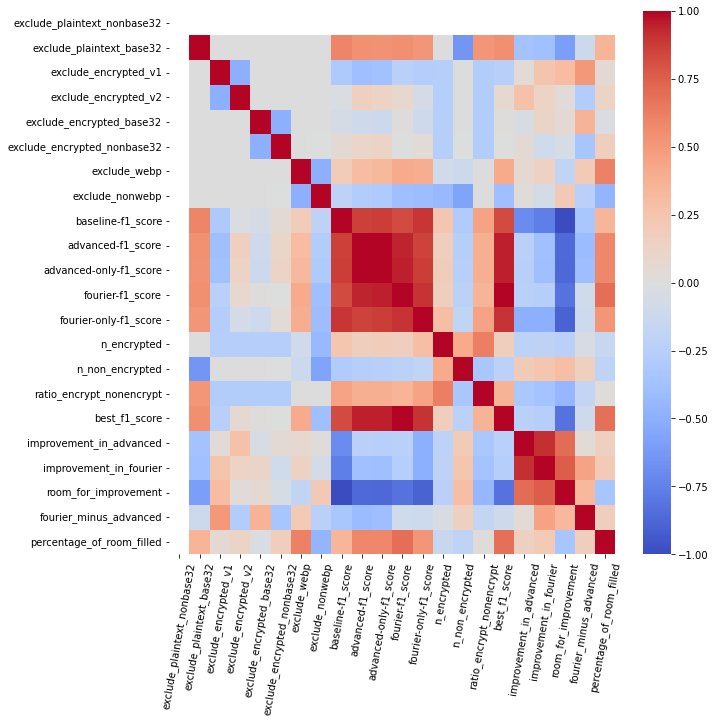

In [ ]:
import seaborn as sns
plt.rcParams["figure.figsize"] = (10,10)
sns.heatmap(df.astype(float).corr(), cmap='coolwarm')
# print(df[df["baseline-f1_score"] > 0.9].astype(float))
_ = plt.xticks(rotation=80) 

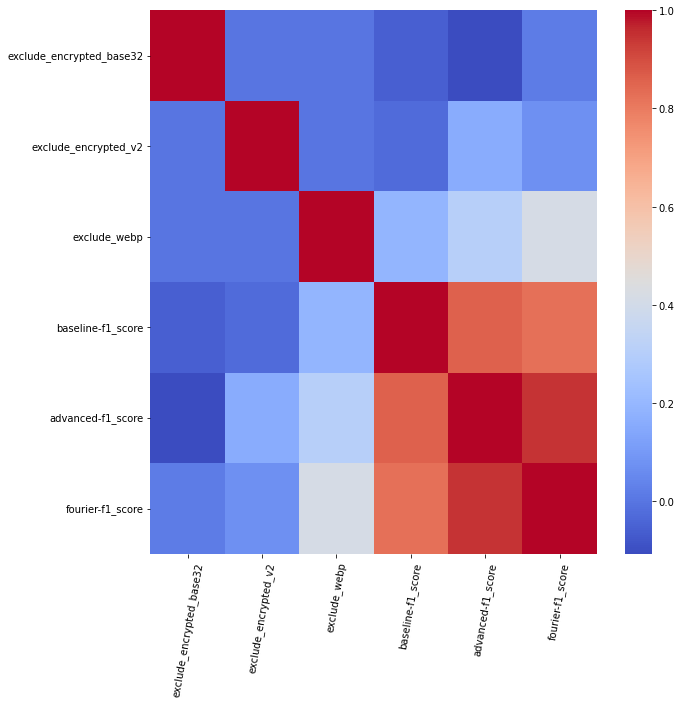

In [ ]:
df1 = df[["exclude_encrypted_base32", "exclude_encrypted_v2", "exclude_webp", "baseline-f1_score", "advanced-f1_score", "fourier-f1_score"]]
sns.heatmap(df1.astype(float).corr(), cmap='coolwarm')
_ = plt.xticks(rotation=80) 

### Average out all the metrics <a class="anchor" id="mean-fscores">

To conclude we report the average of the f1-scores and the improvements with all datasets
    
[top](#Contents)

In [ ]:
df[[c for c in df.columns if ("score" in c or "improvement" in c) and "room" not in c]].mean()

baseline-f1_score          0.577340
advanced-f1_score          0.710232
advanced-only-f1_score     0.700871
fourier-f1_score           0.766661
fourier-only-f1_score      0.620752
best_f1_score              0.767940
improvement_in_advanced    0.132891
improvement_in_fourier     0.189320
dtype: float64

In [ ]:
df[[c for c in df.columns if ("score" in c or "improvement" in c) and "room" not in c]].describe()

,baseline-f1_score,advanced-f1_score,advanced-only-f1_score,fourier-f1_score,fourier-only-f1_score,best_f1_score,improvement_in_advanced,improvement_in_fourier
count,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000
mean,0.577340,0.710232,0.700871,0.766661,0.620752,0.767940,0.132891,0.189320
std,0.330152,0.242409,0.249414,0.221063,0.356735,0.220068,0.173406,0.194050
min,0.000000,0.002253,0.000000,0.121932,0.000000,0.132504,-0.025282,0.000000
25%,0.331869,0.600574,0.562187,0.648100,0.497884,0.648208,0.018926,0.046469
50%,0.682053,0.732800,0.715985,0.808001,0.708895,0.808001,0.083572,0.121819
75%,0.831554,0.907830,0.908704,0.950466,0.928237,0.950466,0.161259,0.296726
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.894079,0.917318


In [ ]:
df1 = df[[c for c in df.columns if ("score" in c or "improvement" in c) and "room" not in c]]
columns = ["baseline-f1_score"]
columns += [c for c in df1.columns if "only" in c]
columns += [c for c in df1.columns if "only" not in c and "baseline-f1_score" != c]
df1[columns].describe()

,baseline-f1_score,advanced-only-f1_score,fourier-only-f1_score,advanced-f1_score,fourier-f1_score,best_f1_score,improvement_in_advanced,improvement_in_fourier
count,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000
mean,0.577340,0.700871,0.620752,0.710232,0.766661,0.767940,0.132891,0.189320
std,0.330152,0.249414,0.356735,0.242409,0.221063,0.220068,0.173406,0.194050
min,0.000000,0.000000,0.000000,0.002253,0.121932,0.132504,-0.025282,0.000000
25%,0.331869,0.562187,0.497884,0.600574,0.648100,0.648208,0.018926,0.046469
50%,0.682053,0.715985,0.708895,0.732800,0.808001,0.808001,0.083572,0.121819
75%,0.831554,0.908704,0.928237,0.907830,0.950466,0.950466,0.161259,0.296726
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.894079,0.917318
